# Introduction

In statistics, and particularly psichobiological resesrch, composite scores are commonly calculated from multiple variables in order to form simple, reliable and valid measures of latent, theoretical constructs (Babbie, 2016).

A common approach is to convert each variable to a z-score and then unit-weight the variables (i.e., take a simple sum of z-scores). This in some sense represents an equal weighting that controls for the fact that the variables are on different metrics (Bobko et al, 2007).

Such simplistic composite scores are frequently used in pain research, as well, e.g. to describe intensity of chronic pain (Jensen et al., 1999), .., or pain sensitivity (Zunhammer et al., 2016).

The latter one, hereafter called the Zunhammer-score, is a composite score based on pain thresholds assessed in three different sensory modalities, namely heat, cold and mechanical pain thresholds (HPT, CPT and MPT, respecuvely), as measured via Quantitative Sensory Testing (QST).

# Aim

In this python notebook, we perform a multi-stage analysis to investigate the rationale of using the composite pain sensitivity score as defined by (Zunhammer et al., 2016) for predictive modelling purposes.


# Overview of the analysis

Most of the composite scales are assumed by their developers and users to be primarily a measure of one latent variable. When it is also assumed that the scale conforms to the effect indicator model of measurement (as is almost always the case in psychological assessment), it is important to support such an interpretation with evidence regarding the internal structure of that scale. 

After importing neccessary python modules and loading the data, here we perform three stages of analysis, addressing three key question:
- Question 1. Is there a common, modality-independent component shared across the investigated pain modalities?
- Question 2. Do the "Zunhammer-score" captures the shared, modality-independent component
- Question 3. Do we have evidence that the prediction (the RPN-score, trained using the Zunhammer-sxcore) captures the shared, modality-independnet component?
- Question 4. To what extent is the RPN-score biased towards any of the modalities? Is its correlation with the single thresholds lower than excpeted from its correlation to the Zunhammer-score?


# Import neccessary modules and load data.

In [22]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns; sns.set()
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')
from mlxtend.evaluate import permutation_test
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import statsmodels.api as sm

# Load all data:
study1 = pd.read_csv("../res/bochum_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity", "prediction"]]
study2 = pd.read_csv("../res/essen_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity", "prediction"]]
study3 = pd.read_csv("../res/szeged_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity", "prediction"]]
study1["study"]="Study 1"
study2["study"]="Study 2"
study3["study"]="Study 3"
df = pd.concat([study1, study2, study3])
df = df.dropna()

# Question 1: Is there a common, modality-independent component shared across the investigated pain modalities?

We invetsigate heat, cold and mechanical pain thresholds (HPT, CPT and MPT, respecuvely), as measured via Quantitative Sensory Testing (QST) with the aim of identifying any shared, modality-independent component.

Specifically, we assume that all three variables consist of three compomnents:
- a modality-specific component (different for heat, cold and mechanical stimuli)
- a modality-independent component (shared between heat, cold and mechanical stimuli)
- an additional "noise" component (e.g. confounds specific for the different measures, like reaction time confounds, skin physiology, etc.)


## Step 1. McDonald's omega

McDonald's Omega as a measure of internal consistency. It measures whether several items that propose to measure the same general construct produce similar scores. 

**Possible outcomes and interpretations:**
- values above 0.7 are, by convention, interpreted as evidence for an accaptable internal consistency.
- values between 0.6 and 0.7 imply "questionable" internal conasistency.
- values between 0.5 and 0.6 imply "poor" internal conasistency.
- values below 0.5 imply no internal conasistency.

Let us note, that using McDonald's Omega does NOT fit to the present data, as HPT, CPT and MPT are NOT meant to measure the same latent variable. Nevertheless, calculating McDonald's Omega is frequently done in relation with composite variables.

**R-code:**

> ``` 
# load data into data.frame called df
library(psych)
omega(df)
```

**Results:**

Omega total was found to be 0.62.

**Interpretation:**

If the variables were ment to measure exclusively the same latent variable, this value would suggest a questionable internal consistency of measurements.

As the McDonald's omega does not fit well to the question at hand, we continue with having a detailed look on:
- the correlations between the variables (Step 2),
- and the underlying latent components by means of principal component analysis (Step 3).


## Step 2. Correlation analysis

As a first step, we investigate, whether these pain thresholds correalte across subjects (data is pooled from three stiudies). 

**Possible outcomes and interpretations:**

- If all thresholds are found to be *strongly collinear*, we have a strong evidence for a modality-independent component of sensitivity to pain
- If the thresholds are *orthogonal* (not correlated), the presence of a modality-independent component of sensitivity to pain cannot be confirmed, and if it exists, its effect is most probably small, as comopared to the other two components (the modality-specific and the "noise" components).
- "In-between" result: One or two out of the total number of three correlations (HPT-CPT, HPT-MPT, CPT-MPT) are significantly correalted. This result might support a modality-independent component which was under detection threshold for one of the modalities or, alternatively, shared only between two modalities.

cor(HPT, CPT) = -0.5063125884777612
Permuation-based p = 0.0
cor(HPT, MPT_log_geom) = 0.19267290368321235
Permuation-based p = 0.0336
cor(CPT, MPT_log_geom) = -0.06731140025472557
Permuation-based p = 0.2651
Mean correlation: 0.2554322974718997
Permuation-based p = 0.0


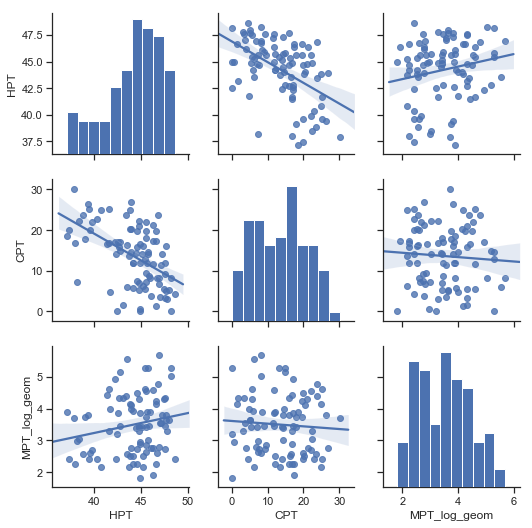

In [24]:
sns.pairplot(df[["HPT", "CPT", "MPT_log_geom", "study"]], kind="reg") 
# tip: add hue="study", to see data separately for each study

p_value = permutation_test(df['HPT'], df['CPT'],
                           method='approximate',
                           func=lambda x, y: -np.corrcoef(x, y)[1][0],
                           num_rounds=10000,
                           seed=0)
print("cor(HPT, CPT) = " + str(np.corrcoef(df['HPT'], df['CPT'])[0,1]))
print("Permuation-based p = " + str(p_value))

p_value = permutation_test(df['HPT'], df['MPT_log_geom'],
                           method='approximate',
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           num_rounds=10000,
                           seed=0)
print("cor(HPT, MPT_log_geom) = " + str(np.corrcoef(df['HPT'], df['MPT_log_geom'])[0,1]))
print("Permuation-based p = " + str(p_value))

p_value = permutation_test(df['CPT'], df['MPT_log_geom'],
                           method='approximate',
                           func=lambda x, y: -np.corrcoef(x, y)[1][0],
                           num_rounds=10000,
                           seed=0)
print("cor(CPT, MPT_log_geom) = " + str(np.corrcoef(df['CPT'], df['MPT_log_geom'])[0,1]))
print("Permuation-based p = " + str(p_value))

p_value = permutation_test(df['HPT'], df['CPT'], 
                           method='approximate',
                           func=lambda x, y: np.mean(np.abs([np.corrcoef(x, y)[0,1],
                                         np.corrcoef(x, df['MPT_log_geom'])[0,1],
                                         np.corrcoef(y, df['MPT_log_geom'])[0,1]])),
                           num_rounds=1000, #set to 10000 for more accuracy
                           seed=0)
print("Mean correlation: " + str(np.mean(np.abs([np.corrcoef(df['HPT'], df['CPT'])[0,1],
                                         np.corrcoef(df['HPT'], df['MPT_log_geom'])[0,1],
                                         np.corrcoef(df['CPT'], df['MPT_log_geom'])[0,1]])
                                        )))
print("Permuation-based p = " + str(p_value))


### Results

Two out of the three possible correlations (HPT-CPT and HPT-MPT) are significant.

The mean correlation is significant p<0.001.

Let's plot it as a network to aid interpretation:

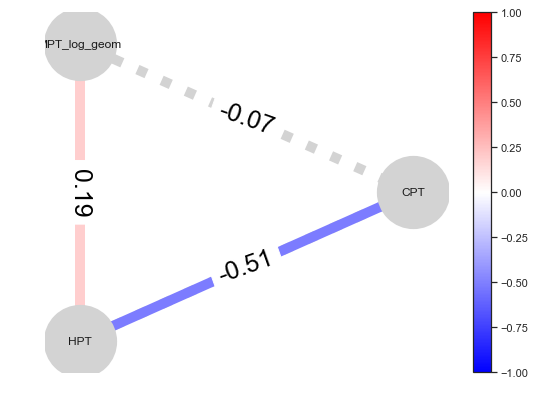

In [25]:
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
corr = df[["HPT", "CPT", "MPT_log_geom", "study"]].corr()
corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links['value']=np.round(links['value'], decimals=2)
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', edge_attr='value')

significant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
significant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
nonsignificant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
nonsignificant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
    
# Plot the network:
pos = nx.circular_layout(G)
plt.figure(3,figsize=(7,5)) 
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=4000,
         edge_color='lightgray', linewidths=10, width=10, style='dotted')
edges=nx.draw_networkx_edges(G, pos, edge_color=significant_value, edgelist=significant, width=10,
                             edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vmax=1)

plot=nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=nx.get_edge_attributes(G,'value'),#{('HPT','CPT'):'*',('HPT','MPT_log_geom'):'*',('CPT','MPT_log_geom'):''},
                             font_color='black', 
                             font_size=25)

colorbar=plt.colorbar(edges)


Dotted lines and light gray color mean no significance and solid lines mean significant correlation and are color-coded, according to tghe legend.

As shown by this plot, the correlation structure of the pain threshold data shows that:
- there is a relationship (or shared component) between the thermal thresholds (HPT and CPT), implyed by a strong, significant correlation.
- there is also a relationship (or shared component) between HPT and MPT, implyed by a weaker, but still significant correlation.

### Interpretation

Two interpretations are possible:
- There IS a single *shared componet across all three modalities*, but we were unable to detect the CPT-MPT relationship in the current sample (e.g. because it is "abolsihed" by the modality-speceific asnd noise components, which are of different magnitude in various modalities)
- There is NO shared component between CPT and MPT, but there is one shared component between HPT and CPT and another between HPT and MPT. 

The current analysis is unable to decide between the above options. 

**Solution: ** unsupervised dimension reduction analysis (Step 3). 

## Step 3. Principal Component Analysis

We perform a Principal Component Analysis (PCA) and investigate the contribution ("loadings") of each modality to the principal components of the data in order to determine, which interpretation from above fits the data better.
Significance of contributions will be investigated by a permutations test.

**Possible outcomes and interpretations:**

- If we find a principal component that holds significant contributions from all three variables, it can be consaidered as an evodence for a common shared component.
- If to all of the principal components there is at least one modality that does not have a significant contribution, then there is, most probably, no component that is shared across *all three* modalities, or the variance explained by this component is too small to be captured by PCA.

Let's do PCA on the original (unpermuted) data and plot the contribution-matrix (loadings).

,PC1,PC2,PC3
HPT,0.745046,0.086474,0.239769
CPT,0.424109,0.158420,0.385858
MPT,0.221024,0.595476,0.067835


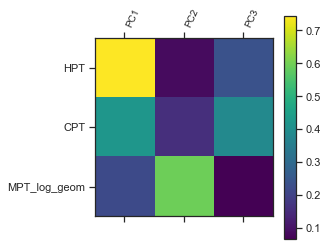

In [28]:
scaler = RobustScaler()
df_pca=df[["HPT", "CPT", "MPT_log_geom"]]
df_pca.loc[:,'HPT'] *= -1  # to align directions of scsales
df_pca.loc[:,'MPT_log_geom'] *= -1  # to align directions of scsales
data_rescaled = scaler.fit_transform(df_pca)
pca = PCA(n_components=3)
pca.fit(data_rescaled)
principal_components=pca.transform(data_rescaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.matshow(np.abs(loadings),cmap='viridis')
plt.xticks([0,1,2],['PC1','PC2','PC3'],fontsize=10, rotation=65,ha='left')
plt.colorbar()
plt.yticks(range(len(df[["HPT", "CPT", "MPT_log_geom"]].columns.values)),
           df[["HPT", "CPT", "MPT_log_geom"]].columns.values)
#plt.tight_layout()
original_loadings=loadings
pd.DataFrame(np.abs(original_loadings), columns=['PC1','PC2','PC3'], index=["HPT", "CPT", "MPT"])

Principal component 1 (PC1) is obviously driven by the thermal thersholds (HPT and CPT), however it is of question, whether the contribution of MPT to PC1 is significant.

Therefore, we permute MPT and repeat the PCA to construct a p-value for the above question.

In [31]:
np.random.seed(0) # for reproducibility
numperms=1000 # set to 10000 for more accurate results
all_loadings=np.zeros(numperms)
# permute data
for iperm in tqdm(range(numperms)):
    data_rescaled_perm=pd.DataFrame()
    data_rescaled_perm['HPT'] = data_rescaled[:,0]
    data_rescaled_perm['CPT'] = data_rescaled[:,1]
    data_rescaled_perm['MPT_log_geom'] = np.random.permutation(data_rescaled[:,2])

    data_rescaled_perm
    pca = PCA(n_components=3)
    pca.fit(data_rescaled_perm)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    # contribution of the permuted MPT to PC1
    all_loadings[iperm] = loadings[2,0] 
    
# calculate p-value:
orignal_loading_mpt=original_loadings[2,0]
print("p = ", str(np.sum(all_loadings > orignal_loading_mpt)/len(all_loadings)))


100%|██████████| 1000/1000 [00:04<00:00, 249.26it/s]

p =  0.05


### Results
Both from the correlation analysis and the PCA, it is obvious the HPT and CPT have much more in common than with MPT.
Moreover, the permutation-based p-value of the PCA is around accaptance level (0.049), providing evidence for a **shared component across all three modalities**.

### Interpretation

The most plausible interpretation of these results is that there is a "thermal component" shared between HPT and CPT and another "general component" which is shared across all three modalities. In the study of Spisak et al., this latter component is of interest.
However, the mean composite pain sensitivity, as defined by Zunhammer et al., 2016, most probably captures both the "thermal" and the "general" components, therby meaning a potential bias in the proposed prediction approach (RPN-signature).

To characterise the above mentioned bias, below we evaluate, whether the "Zunhammer-score" and the score predicted by the RPN-signature is correlated with all thre modalities.

# Question 2. Do the "Zunhammer-score" captures the shared, modality-independent component?

### Step 1. PC1 vs. the "Zunhammer-score"

First we test, if the mean of the (scaled) pain thresholds (used in our study as prediction target, first used in Zunhammer et al. 2016, abbreviated as "Zunhammer-score"), similarly to PC1 (defined above) captures the shared component across the three sesnory modalities.

** Possible outcomes and interpretations:**
- the first princial component in the present, collinear dataset is most probably very strongly correalted with the mean allowing for using the mean and PC1 interchangably as prediction target.

In [32]:
# we define a function for computing p-values with permutation test, as this will be applied multiple times
def permtest(A, B, nameA="A", nameB="B", numperm=10000):
    cor=np.corrcoef(A, B)[0,1]
    print("cor(" + nameA + "," + nameB + ") = " + str(cor) )
    p_value = permutation_test(A, B,
                           method='approximate',
                           func=lambda x, y: np.sign(cor)*np.corrcoef(x, y)[1][0],
                           num_rounds=numperm,
                           seed=0)
    if p_value==0:
        print("Permuation-based p < " + str(1.0/numperm))
    else:
        print("Permuation-based p = " + str(p_value))
    
permtest(df['mean_QST_pain_sensitivity'], principal_components[:,0], "Zunhammer-score", "PC1")   

cor(Zunhammer-score,PC1) = 0.9259546424719092
Permuation-based p < 0.0001


** Result: **

As expected, the mean strongly correlates with the first principal component, therefore, most probably, captures the shared component of interest.

Let us plot the data as a network:

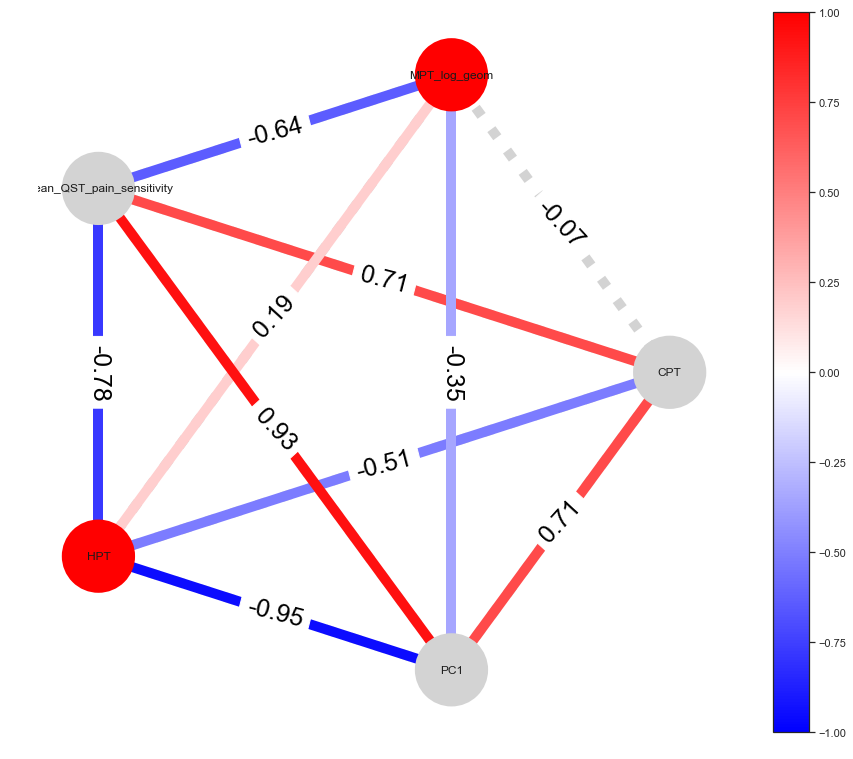

In [33]:
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
tmpdf=df[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity"]]
tmpdf['PC1']=principal_components[:,0]
tmpdf=tmpdf[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity", 'PC1']] # just to fix order of columns
corr = tmpdf.corr()
corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links['value']=np.round(links['value'], decimals=2)
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', edge_attr='value')

significant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
significant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
nonsignificant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
nonsignificant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
    
# Plot the network:
pos = nx.circular_layout(G)
plt.figure(3,figsize=(12,10)) 
nx.draw(G, pos, with_labels=True, node_color=['lightgray', 'red', 'lightgray', 'red', 'lightgray'],
        node_size=4000, edge_color='lightgray', linewidths=10, width=10, style='dotted')
edges=nx.draw_networkx_edges(G, pos, edge_color=significant_value, edgelist=significant, width=10,
                             edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vmax=1)

plot=nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=nx.get_edge_attributes(G,'value'),#{('HPT','CPT'):'*',('HPT','MPT_log_geom'):'*',('CPT','MPT_log_geom'):''},
                             font_color='black', 
                             font_size=25)

colorbar=plt.colorbar(edges)



As above, dotted lines mean no significance (only one correlation, between MPT and CPT) and solid lines mean significant correlation.

**Interpretation:**

As expected, the comosite pain sensitivity scores (red nodes), namely PC1 and the Zunhammer-score (denoted as "mean_QST_pain_sensitivity" on the figure) are *significantly correalted with all modalities*, including MPT.
This suggests, that similarly to PC1 (as shown above) the Zunhammer-score is also able to capture the shared component of interest.

Let's look at the single data points to confirm that correlations between the Zunhammer-score and the single modalities are NOT driven by e.g. outliers.

Correlation with the Zunhammer-score:
cor(HPT,Zunhammer-score) = -0.7797640399729854
Permuation-based p < 0.0001
cor(CPT,Zunhammer-score) = 0.7055498458988412
Permuation-based p < 0.0001
cor(MPT,Zunhammer-score) = -0.6396260726198744
Permuation-based p < 0.0001


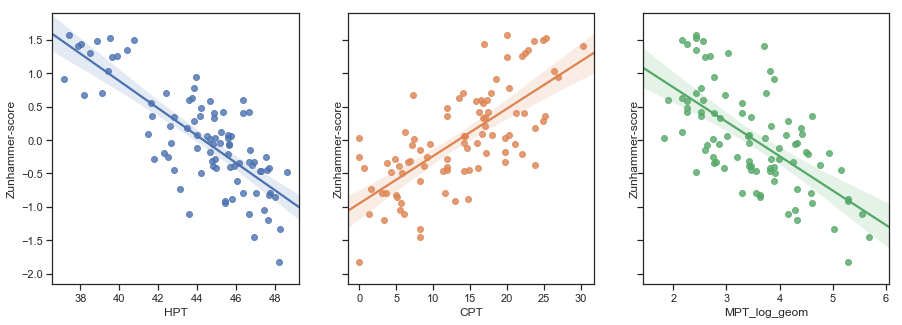

In [34]:
# Plot correlation with the "Zunhammer-score"
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x=df['HPT'], y=df['mean_QST_pain_sensitivity'], ax=ax1)
ax1.set_ylabel('Zunhammer-score')
sns.regplot(x=df['CPT'], y=df['mean_QST_pain_sensitivity'], ax=ax2)
ax2.set_ylabel('Zunhammer-score')
sns.regplot(x=df['MPT_log_geom'], y=df['mean_QST_pain_sensitivity'], ax=ax3)
ax3.set_ylabel('Zunhammer-score')
ran=np.max(df['mean_QST_pain_sensitivity'])-np.min(df['mean_QST_pain_sensitivity'])
plt.ylim(np.min(df['mean_QST_pain_sensitivity'])-0.1*ran, np.max(df['mean_QST_pain_sensitivity'])+0.1*ran)
ran=np.max(df['MPT_log_geom'])-np.min(df['MPT_log_geom'])
ax3.set_xlim(np.min(df['MPT_log_geom'])-0.1*ran,np.max(df['MPT_log_geom'])+0.1*ran)


# compute p-values with permutation test 
print("Correlation with the Zunhammer-score:")
permtest(df['HPT'], df['mean_QST_pain_sensitivity'], 'HPT', 'Zunhammer-score')
permtest(df['CPT'], df['mean_QST_pain_sensitivity'], 'CPT', 'Zunhammer-score')
permtest(df['MPT_log_geom'], df['mean_QST_pain_sensitivity'], 'MPT', 'Zunhammer-score')

# Questin 3. Do we have evidence that the prediction (the RPN-score, trained using the Zunhammer-sxcore) captures the shared, modality-independnet component? 

**So far, we have shown that:**
- the first all three modalities (HPT, CPT and MPT) significantly contribute to the first princial component (PC1) of the data, suggesting the existence of a shared, modality-independent component of pain sensitivity.
- and the Zunhammer-score, used in our study as a proxy for modality-independent pain sensitivity and prediction target, very strongly correlates with PC1, therefore, most probably incorporates  the shared, modality-independent component of interest.

At this point, however, we cannot exclude the possibility, that the Zunhammer-score is dominated by other componets (e.g. thermal modality-specific or noise) so much that using it as a prediction target, in the end of the day, falls back to the prediction of modality-specific components.

In this case, we could expect that the output of the RPN-signature predictive model, trained with the Zunhammer-score (the RPN-score) will correalte with the single modlaities *only in the training set* and will *fail to generalize in the independent validation studies* to, at least, one of the singel modalities.

** *NOTE:* ** The RPN-signature was trained with the compoite Zunhammer-score and was blind to the single scores, already during the trainig smample.

We test, how well the *composite score-based* RPN prediction generalizes to the single modalities by leaving out modalities when computing the observed composite score. Specifically, this involves an analysis of leaving out one modality (Step 1) and leaving out two modalities, i.e. reatining only one modality.

### Step 1.  "Leave-one-modality-out" analysis

In this analysis, we calculate two-modality summary scores with the same method used for the Zunhammer-score.
Comparing these "leave-one-modality-out" scores to the RPN-score provides insights into the generalizability of the RPN-signature to combinations of different modalities and potentially, adding a new modality.

Correlation with the RPN-score:
cor(Zunhammer(HPT,CPT),RPN-score) = 0.4575562457450685
Permuation-based p < 0.0001
cor(Zunhammer(HPT,MPT),RPN-score) = 0.4291506440039318
Permuation-based p < 0.0001
cor(Zunhammer(CPT,MPT),RPN-score) = 0.40012762722771095
Permuation-based p < 0.0001


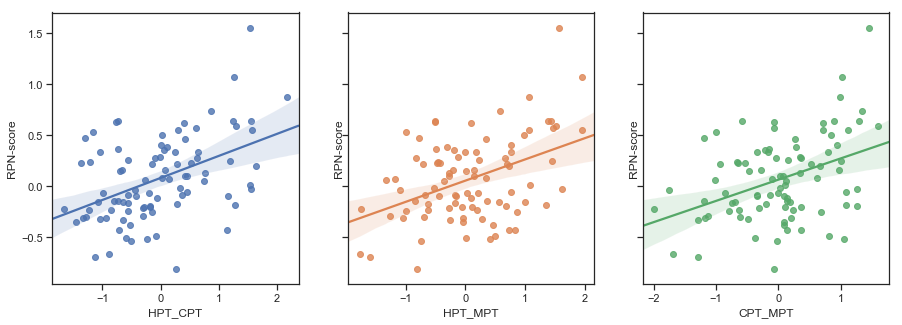

In [35]:
# calculate leave-one-modality-out summary scores (analogously to the Zunhammer-score)
# means and standard deviations from Study1 (Bochum-sample):
# these values are hard-coded into the calculation of the Zunhammer-score,
# so that its calculation is independent of the data at hand
b_hpt_mean=44.21297
b_hpt_sd=2.799718
b_cpt_mean=14.35385
b_cpt_sd=7.595601
b_mpt_mean=3.617695
b_mpt_sd=0.801178

hpt_scaled=-(df['HPT']-b_hpt_mean)/b_hpt_sd
cpt_scaled=(df['CPT']-b_cpt_mean)/b_cpt_sd
mpt_scaled=-(df['MPT_log_geom']-b_mpt_mean)/b_mpt_sd

df_lomo=df #lomo:leave-one-modality-out
df['HPT_CPT']=(hpt_scaled+cpt_scaled)/2
df['HPT_MPT']=(hpt_scaled+mpt_scaled)/2
df['CPT_MPT']=(cpt_scaled+mpt_scaled)/2

# Plot correlation with the "RPN-score"
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x=df['HPT_CPT'], y=df['prediction'], ax=ax1)
sns.regplot(x=df['HPT_MPT'], y=df['prediction'], ax=ax2)
sns.regplot(x=df['CPT_MPT'], y=df['prediction'], ax=ax3)
ax1.set_ylabel('RPN-score')
ax2.set_ylabel('RPN-score')
ax3.set_ylabel('RPN-score')

# compute p-values with permutation test
print("Correlation with the RPN-score:")
permtest(df['HPT_CPT'], df['prediction'], 'Zunhammer(HPT,CPT)', 'RPN-score')
permtest(df['HPT_MPT'], df['prediction'], 'Zunhammer(HPT,MPT)', 'RPN-score')
permtest(df['CPT_MPT'], df['prediction'], 'Zunhammer(CPT,MPT)', 'RPN-score')

**Result: **

All possible leave-one-modality-out scores were significantly predicted by RPN-score.

**Interpretation:**

The RPN-signature is NOT driven by one modality only, and stays robust for different definitions of "composite pain sensitivity".

### Step 2.  "Leave-two-modalities-out" analysis
Leaving out two modalities equals with simply testing the relationship of the compoite RPN-score with the single modalities (HPT, CPT and MPT)

Correlation with the RPN-score:
cor(HPT,RPN-score) = -0.43644372163377854
Permuation-based p < 0.0001
cor(CPT,RPN-score) = 0.35617457477513276
Permuation-based p = 0.0005
cor(MPT,RPN-score) = -0.24024492612674364
Permuation-based p = 0.0129


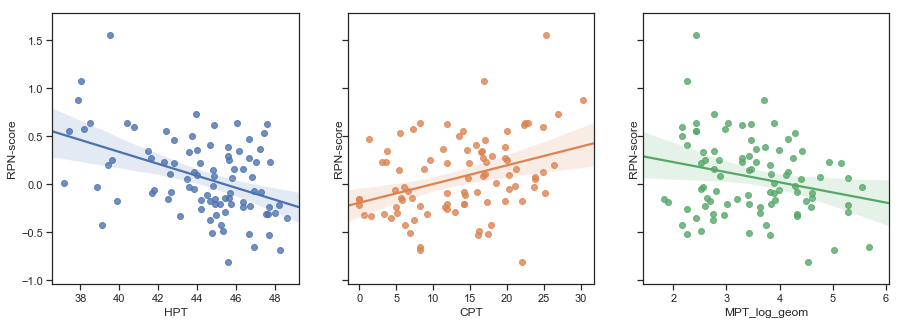

In [36]:
# Plot correlation with the "RPN-score"
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x=df['HPT'], y=df['prediction'], ax=ax1)
sns.regplot(x=df['CPT'], y=df['prediction'], ax=ax2)
sns.regplot(x=df['MPT_log_geom'], y=df['prediction'], ax=ax3)
ran=np.max(df['prediction'])-np.min(df['prediction'])
plt.ylim(np.min(df['prediction'])-0.1*ran, np.max(df['prediction'])+0.1*ran)
ran=np.max(df['MPT_log_geom'])-np.min(df['MPT_log_geom'])
ax3.set_xlim(np.min(df['MPT_log_geom'])-0.1*ran,np.max(df['MPT_log_geom'])+0.1*ran)
ax1.set_ylabel('RPN-score')
ax2.set_ylabel('RPN-score')
ax3.set_ylabel('RPN-score')

# compute p-values with permutation test
print("Correlation with the RPN-score:")
permtest(df['HPT'], df['prediction'], 'HPT', 'RPN-score')
permtest(df['CPT'], df['prediction'], 'CPT', 'RPN-score')
permtest(df['MPT_log_geom'], df['prediction'], 'MPT', 'RPN-score')

**Result:**

All possible leave-two-modality-out scores, i.e. all three pain modalitioes were significantly predicted by RPN-score.

**Interpretation:**

The RPN-signature is NOT exclusively driven by any combination of two modalities, specifically, not only driven by the thermal thresholds.
The RPN-score hold predictive values for all modalities, evenm though it was trained to predict the modality-independent compoitse pain sensitivity (the Zunhammer-score).


# Question 4. To what extent is the RPN-score biased towards any of the modalities? Is its correlation with the single thresholds lower than excpeted from its correlation to the Zunhammer-score?

This analysis aims to exclude the possibility that the RPN-score is biased e.g. towards thermal thersholds.

We will employ "simulated" RPN-scores that are constructed by adding Gaussian noise to the Zunhammer-score, so that the correlation of these simulated scores with the Zunhammer-score equals to the correlation of the RPN-score to the Zunhammer-score. For the sake of simplicity, we refer to these simuklates scores as "noisy Zunhammers".

The correlation of many noisy Zunhammers to the single pain thresholds (HPT, CPT, MPT) will be used to construct a null distribution for these correlations. Then, the actual RPN-single thresholds correlations will be contrasted to these null distributions to obtain p-values. The test is one sided, testing for "negative bias" (smaller correlation than expected).

**Possible outcomes and interpretations:**
- a significant p-value implies a strong bias against the given modality, meaning that the the degree to which the RPN-signature generalizes to the single pain thresholds significantly differs from what we can expect given its correlation to the Zunhammer-score.
- p-values gerater than the alpha-level (p>0.05) means that our data provides no evidence for significant bias of the RPN-score towards any of the single pain modalities.

100%|██████████| 1000/1000 [00:01<00:00, 745.28it/s]


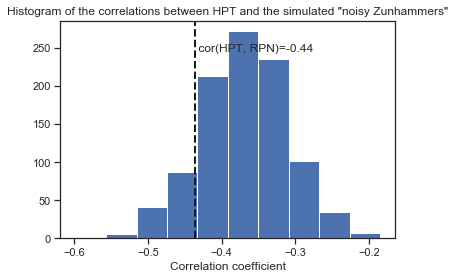

p =  0.873


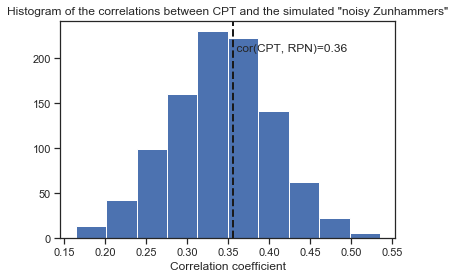

p =  0.583


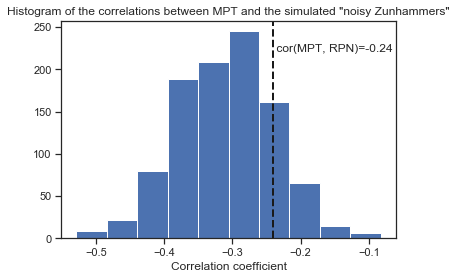

p =  0.166


In [37]:
old_df=df
df=df#study3.dropna()

cor_Zunhammer_rpn = np.corrcoef(df['mean_QST_pain_sensitivity'], df['prediction'])[0,1]

np.random.seed(1)
num_sim=1000

# a nice tricky function to genberate random noisy Zunhammers: variables with a given correlation to the Zunhammer-score
# ported to python from: https://stats.stackexchange.com/questions/15011/generate-a-random-variable-with-a-defined-correlation-to-an-existing-variables
def get_noisy_Zunhammer(rho=cor_Zunhammer_rpn, y=df['mean_QST_pain_sensitivity'], x=None, seed=None):
    if (not x):
        if seed is not None:
            np.random.seed(seed)
        x = np.random.normal(0,1,len(y))
    y=np.array(y)
    x=np.array(x)
    y_perp = sm.OLS(x,sm.tools.tools.add_constant(y)).fit().resid
    return( rho * np.std(y_perp, ddof=1) * y + y_perp * np.std(y, ddof=1) * np.sqrt(1 - rho**2.0) )

rhos_noisyZunhammer_Zunhammer=np.zeros(num_sim)
rhos_noisyZunhammer_HPT=np.zeros(num_sim)
rhos_noisyZunhammer_CPT=np.zeros(num_sim)
rhos_noisyZunhammer_MPT=np.zeros(num_sim)

Zunhammer_std = (df['mean_QST_pain_sensitivity']-np.mean(df['mean_QST_pain_sensitivity']))/-np.std(df['mean_QST_pain_sensitivity'])

# simulate noisy Zunhammers
for sim_i in tqdm(range(num_sim)):
    # cereate a "noisy Zunhammer"
    noisy_Zunhammer=get_noisy_Zunhammer()
    # calculate the correlation of the noisy Zunhammer and the observed Zunhammer-score
    rhos_noisyZunhammer_Zunhammer[sim_i]=np.corrcoef(df['mean_QST_pain_sensitivity'], noisy_Zunhammer)[0,1]
    # calculate the correlation between the noisy Zunhammer and the single pain thershodls
    rhos_noisyZunhammer_HPT[sim_i]=np.corrcoef(df['HPT'], noisy_Zunhammer)[0,1]
    rhos_noisyZunhammer_CPT[sim_i]=np.corrcoef(df['CPT'], noisy_Zunhammer)[0,1]
    rhos_noisyZunhammer_MPT[sim_i]=np.corrcoef(df['MPT_log_geom'], noisy_Zunhammer)[0,1]

    
#assess p-values based on the null distributions of correlations between the noisy Zunhammers and HPT
cor_HPT_RPN=np.corrcoef(df['HPT'], df['prediction'])[0,1]
hist=plt.hist(rhos_noisyZunhammer_HPT)
plt.title("Histogram of the correlations between HPT and the simulated \"noisy Zunhammers\"")
plt.xlabel("Correlation coefficient")
plt.axvline(cor_HPT_RPN, color='k', linestyle='dashed', linewidth=2)
text=plt.text(cor_HPT_RPN, np.max(hist[0])*0.9, " cor(HPT, RPN)=" + str(np.round(cor_HPT_RPN, 2)))
plt.show()
print("p = ", str(np.sum(rhos_noisyZunhammer_HPT > cor_HPT_RPN)/num_sim) )


#assess p-values based on the null distributions of correlations between the noisy Zunhammers and CPT
cor_CPT_RPN=np.corrcoef(df['CPT'], df['prediction'])[0,1]
hist=plt.hist(rhos_noisyZunhammer_CPT)
plt.title("Histogram of the correlations between CPT and the simulated \"noisy Zunhammers\"")
plt.xlabel("Correlation coefficient")
plt.axvline(cor_CPT_RPN, color='k', linestyle='dashed', linewidth=2)
text=plt.text(cor_CPT_RPN, np.max(hist[0])*0.9, " cor(CPT, RPN)=" + str(np.round(cor_CPT_RPN, 2)))
plt.show()
print("p = ", str(np.sum(rhos_noisyZunhammer_CPT < cor_CPT_RPN)/num_sim) )


#assess p-values based on the null distributions of correlations between the noisy Zunhammers and MPT
cor_MPT_RPN=np.corrcoef(df['MPT_log_geom'], df['prediction'])[0,1]
hist=plt.hist(rhos_noisyZunhammer_MPT)
plt.title("Histogram of the correlations between MPT and the simulated \"noisy Zunhammers\"")
plt.xlabel("Correlation coefficient")
plt.axvline(cor_MPT_RPN, color='k', linestyle='dashed', linewidth=2)
text=plt.text(cor_MPT_RPN, np.max(hist[0])*0.9, " cor(MPT, RPN)=" + str(np.round(cor_MPT_RPN, 2)))
plt.show()
print("p = ", str(np.sum(rhos_noisyZunhammer_MPT > cor_MPT_RPN)/num_sim) )

df=old_df

**Results:**

All p-values are gerater than 0.05.

**Interpretation:**

**We found no evidence of negative bias towards any of the pain modalioties.**
While our results are not conclusive in that respect, we can specuklate, that the relatively low p-value for MPT might imply that the RPN-score can capture changes in mechanical pain threshold top a somewhat lesser degree, than expected.



# Conclusion

In statistics, and particularly biomedical resesrch, composite scores are commonly calculated from multiple variables in order to form simple, reliable and valid measures of latent, theoretical constructs (Babbie, 2016).

A common approach is to convert each variable to a z-score and then unit-weight the variables (i.e., take a simple sum of z-scores). This in some sense represents an equal weighting that controls for the fact that the variables are on different metrics (Bobko et al, 2007).

Such simplistic composite scores are frequently used in pain research, as well, e.g. to describe intensity of chronic pain (Jensen et al., 1999), .., or pain sensitivity (Zunhammer et al., 2016).



In this python notebook, we perform a multi-stage analysis to investigate the rationale for using the composite pain sensitivity score as defined by (Zunhammer et al., 2016) for predictive modelling purposes.




Most of these scales are assumed by their developers and users to be primarily a measure of one latent variable. When it is also assumed that the scale conforms to the effect indicator model of measurement (as is almost always the case in psychological assessment), it is important to support such an interpretation with evidence regarding the internal structure of that scale. 

(Zunhammer et al., 2016)




# References

Zunhammer et al., 2016. ...

(Babbie, 2016) Babbie ER. The basics of social research. Cengage learning; page 158. 2013.

(Bobko et al, 2007) Bobko P, Roth PL, Buster MA. The usefulness of unit weights in creating composite scores: A literature review, application to content validity, and meta-analysis. Organizational Research Methods. 2007 Oct;10(4):689-709.

(Jensen et al., 1999) Jensen MP, Turner JA, Romano JM, Fisher LD. Comparative reliability and validity of chronic pain intensity measures. Pain. 1999 Nov 1;83(2):157-62.
